<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 38

# Student 1: Adil Jahouh

# Student 2: Anvitha

# Student 3: Srinidhi Ilango

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

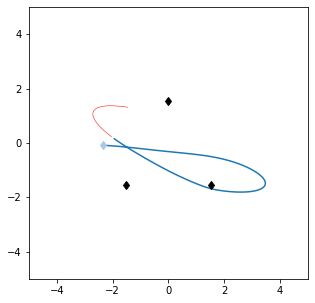

Charges are [-0.37176122 -0.5952179  -0.62247037]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

In [8]:
# saving and loading checkpoint mechanisms 
# modules adapted from https://github.com/ttchengab/One_Shot_Pytorch/blob/master/network.ipynb

def save_checkpoint(save_path, model, optimizer, val_loss):
  """
  Utility function for saving the model 

  Input
    --save_path: path to save the model
    --model: model to be saved
    --optimizer: optimizer to be saved
    --val_loss: lowest validation loss so far

  Output
    Saved model as pt file
  """
  if save_path==None:
      return
  save_path = save_path 
  state_dict = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss}

  torch.save(state_dict, save_path)
  print(f'Model saved to ==> {save_path}')


def load_checkpoint(model, optimizer):
  """
  Utility function to load a saved model
  Input
    --model: model object to load the weights into
    --optimizer: optimizer object
    
  Output:
    Validation loss
  """
  save_path = f'SiameseNetwork.pt'
  state_dict = torch.load(save_path)
  model.load_state_dict(state_dict['model_state_dict'])
  optimizer.load_state_dict(state_dict['optimizer_state_dict'])
  val_loss = state_dict['val_loss']
  print(f'Model loaded from <== {save_path}')
  
  return val_loss

# Task 3.1

## Data Handling and Preprocessing

Here, we deliberated over one of the following two options as the simulations have different lengths:
1. zero padding to match the simulation lenghts
2. without zero padding, pass one simuation at a time into the network and aggregate the outputs for backprop [ref1](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/12#:~:text=2%20MONTHS%20LATER-,GalAvineri,-cdjhz), [ref2](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)

We now try the second option <br>
-- the model should be invariant to rotation, not sure about the implementation
[REF](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/13)

In [9]:
#todo 
#1: can add data normalization later
#2: data augmentation - slice through longer time points as the outputs must remain same
#3: data augmentation - time reveral should not affect the result (#data-pts*2)

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

def collate_batch(batch):
    '''
    Args:
        batch: batch sizes list of tuples (features, target)
    
    Returns:
        packed input simulation and corresponding targets
    
    '''
    data = [torch.from_numpy(item[0]).float() for item in batch]
    lengths = [d.size(0) for d in data]

    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    packed_data = pack_padded_sequence(padded_data, lengths, batch_first=True, enforce_sorted=False)
    
    targets = np.array([item[1] for item in batch])

    return packed_data.to(device), torch.tensor(targets).float().to(device)
    

In [10]:
# defining a DataLoaders for training, validation and testing
 
batch_len = 8

train_loader = DataLoader(tuple(zip(simulation_train, charges_train)), batch_size = batch_len, 
                        collate_fn = collate_batch)#,pin_memory=True)

val_loader = DataLoader(tuple(zip(simulation_valid, charges_valid)), batch_size = batch_len, 
                        collate_fn = collate_batch)#,pin_memory=True)

test_loader = DataLoader(tuple(zip(simulation_test, charges_test)),batch_size=1,
                        collate_fn = collate_batch)#,pin_memory=True)

## Model Implementation

[ref1](https://stackoverflow.com/questions/44643137/how-do-you-use-pytorch-packedsequence-in-code)
[ref2](https://www.crosstab.io/articles/time-series-pytorch-lstm)

In [33]:
#todo: clean up code, understand it better
#can add normalizatoin, dropouts, regularization

from torch import nn

class RegressionLSTM(nn.Module):
    """
    LSTM model to find the charge of three particles
    """
    def __init__(self, inp_size=2, hidden_size=110, n_layers=1, batch_size=8, dropout=0.5):
        super(RegressionLSTM, self).__init__()
        
        self.inp_size = inp_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size

        self.drop = nn.Dropout(p= dropout)        
        self.rnn = nn.LSTM(
            input_size = self.inp_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True
        )

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(in_features=self.hidden_size, out_features=3)

    
    def forward(self, x):
        # h0 = torch.zeros(self.n_layers, self.batch_size ,self.hidden_size).requires_grad_()
        # c0 = torch.zeros(self.n_layers, self.batch_size, self.hidden_size).requires_grad_()
        
        _,(hn,_) = self.rnn(x)#,(h0,c0))
        last_hidden_layer = hn[0]
        last_hidden_layer = self.drop(last_hidden_layer)
        h = self.fc1(last_hidden_layer)
        h  = self.fc2(h)
        # h = nn.Tanh()(h)
        output = nn.Tanh()(h)
        
        # output = self.fc2(h)

        return output

## Model Training

In [34]:
# trainng and validation for every epoch

def train(model, train_loader, val_loader, num_epochs, loss_fn, save_name):

    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for X, y in tqdm(train_loader):
            output = model(X)
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        avg_train_loss = running_loss/ len(train_loader)
        train_losses.append(avg_train_loss)


        val_running_loss = 0.0
        
        with torch.no_grad():
            model.eval()
            for X,y in val_loader:
                output = model(X)
                loss = loss_fn(output, y)
            val_running_loss += loss.item()

            avg_val_loss = val_running_loss/ len(val_loader)
            val_losses.append(avg_val_loss)

        print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}'
                .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))

        if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print('Finished Training!!')
    return train_losses, val_losses


In [35]:
#todo
from tqdm import tqdm 

lr = 1e-5
hidden_units = 16

model = RegressionLSTM(batch_size=batch_len)
model.to(device)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
num_epochs = 30

save_path = 'test_run1.pt'
train_losses, val_losses = train(model, train_loader, val_loader, 
                                num_epochs, loss_fn, save_path)

100%|██████████| 100/100 [00:00<00:00, 112.33it/s]


Epoch [1/30], train_loss: 0.0029, val_loss: 0.0276
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 124.87it/s]


Epoch [2/30], train_loss: 0.0026, val_loss: 0.0261
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 111.10it/s]


Epoch [3/30], train_loss: 0.0023, val_loss: 0.0246
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 121.84it/s]


Epoch [4/30], train_loss: 0.0022, val_loss: 0.0231
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 124.63it/s]


Epoch [5/30], train_loss: 0.0020, val_loss: 0.0214
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 126.00it/s]


Epoch [6/30], train_loss: 0.0019, val_loss: 0.0196
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 120.74it/s]


Epoch [7/30], train_loss: 0.0017, val_loss: 0.0176
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:01<00:00, 97.20it/s]


Epoch [8/30], train_loss: 0.0013, val_loss: 0.0153
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:01<00:00, 96.00it/s]


Epoch [9/30], train_loss: 0.0011, val_loss: 0.0127
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 120.87it/s]


Epoch [10/30], train_loss: 0.0009, val_loss: 0.0099
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 127.71it/s]


Epoch [11/30], train_loss: 0.0008, val_loss: 0.0078
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 114.12it/s]


Epoch [12/30], train_loss: 0.0009, val_loss: 0.0072
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 118.66it/s]


Epoch [13/30], train_loss: 0.0006, val_loss: 0.0071
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 111.37it/s]


Epoch [14/30], train_loss: 0.0008, val_loss: 0.0071
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 119.46it/s]


Epoch [15/30], train_loss: 0.0007, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 114.46it/s]


Epoch [16/30], train_loss: 0.0009, val_loss: 0.0071
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 107.28it/s]


Epoch [17/30], train_loss: 0.0007, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 115.65it/s]


Epoch [18/30], train_loss: 0.0009, val_loss: 0.0071
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 120.15it/s]


Epoch [19/30], train_loss: 0.0007, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 126.28it/s]


Epoch [20/30], train_loss: 0.0009, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 124.78it/s]


Epoch [21/30], train_loss: 0.0008, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 102.47it/s]


Epoch [22/30], train_loss: 0.0008, val_loss: 0.0071
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 101.78it/s]


Epoch [23/30], train_loss: 0.0007, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 126.26it/s]


Epoch [24/30], train_loss: 0.0008, val_loss: 0.0071
Model saved to ==> test_run1.pt


100%|██████████| 100/100 [00:00<00:00, 124.69it/s]


Epoch [25/30], train_loss: 0.0006, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 128.84it/s]


Epoch [26/30], train_loss: 0.0009, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 128.55it/s]


Epoch [27/30], train_loss: 0.0007, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 120.04it/s]


Epoch [28/30], train_loss: 0.0009, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 116.65it/s]


Epoch [29/30], train_loss: 0.0008, val_loss: 0.0071


100%|██████████| 100/100 [00:00<00:00, 128.95it/s]

Epoch [30/30], train_loss: 0.0008, val_loss: 0.0071
Finished Training!!


In [62]:
val_losses[1] 
# train_losses

0.02613144195996798

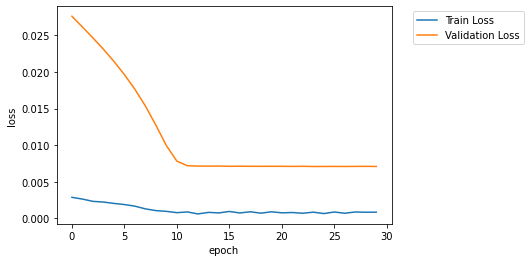

In [63]:
#plotting training vs validation loss

#maybe add more layers to the model, or decrease the learning rate

import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Evaluation

In [64]:
#todo : evaluate the model performance on the test set
#check the training example it performs the worst on 
#try to obtain possible reasons for such performance
for x, y in test_loader:
    print(x[3])
    print(y)
    break

tensor([0], device='cuda:0')
tensor([[-0.5242, -0.6315, -0.6610]], device='cuda:0')


In [65]:
for features,targets in test_loader:
    print(features[0].shape)
    print(targets)
    break

torch.Size([95, 2])
tensor([[-0.5242, -0.6315, -0.6610]], device='cuda:0')


In [66]:
lr = 1e-5
hidden_units = 16

model = RegressionLSTM(batch_size=batch_len)
model.to(device)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
num_epochs = 30

def test(model):
    with torch.no_grad():
        model.eval()
        outputs = []
        labels = []
        for X,y in test_loader:
            output = model(X)
            outputs.append(output)
            labels.append(y)
        return outputs, labels
predictions, actual = test(model)

In [67]:
# for i in predictions:
#     if len(i[i<0]) != 0:
#         print(i[i<0])

In [68]:
def plot_sim(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

16


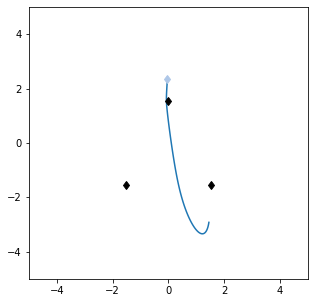

Predictions are [ 0.06017276 -0.0590747  -0.06873702]
Charges are [-0.06704309 -0.12076204 -0.27023168]
Actual charges are are tensor([[-0.0670, -0.1208, -0.2702]], device='cuda:0')
91


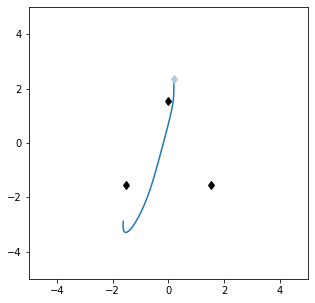

Predictions are [ 0.02278021 -0.00956707 -0.11247772]
Charges are [-0.12278833 -0.09665291 -0.27836428]
Actual charges are are tensor([[-0.1228, -0.0967, -0.2784]], device='cuda:0')


In [59]:
badpredics = []
goodpredics = []
list_actual = []
list_predictions =[]
for index, predic in enumerate(predictions):
    distance = abs(actual[index] - predictions[index])
    list_actual.extend(actual[index].cpu().numpy().tolist()[0])
    list_predictions.extend(predictions[index].cpu().numpy().tolist()[0])
    if distance[0][0] > 0.65 and distance[0][1] > 0.65 and distance[0][2] > 0.65:
        badpredics.append(index)
    if distance[0][0] < 0.3 and distance[0][1] < 0.3 and distance[0][2] < 0.3:
        goodpredics.append(index)
for i in goodpredics:
    print(i)
    plot_sim(simulation_test[i])
    print(f'Predictions are {predictions[i][0].cpu().numpy()}')
    print(f'Charges are {charges_test[i]}')
    print(f'Actual charges are are {actual[i]}')
                # print(i, actual[predic])
        # plot_example(simulation_test[predic])
        # print(f'Charges are {charges_test[predic]}')

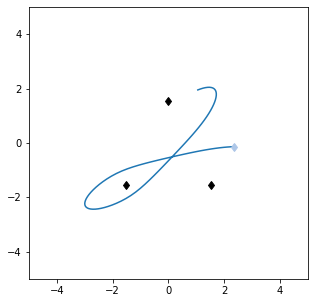

Predictions are [ 0.04128632  0.02006975 -0.06621576]
Charges are [-0.95846316 -0.67919017 -0.75830526]


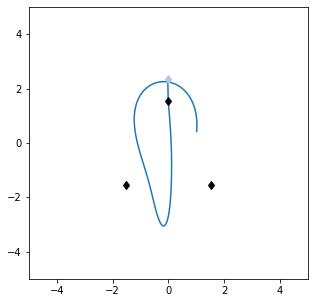

Predictions are [ 0.04286124 -0.00030956 -0.06531869]
Charges are [-0.86127899 -0.65102751 -0.97197486]


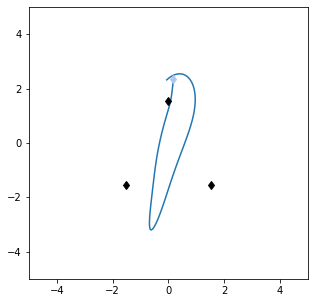

Predictions are [ 0.02827754  0.04967117 -0.08343267]
Charges are [-0.64146604 -0.91733013 -0.8782985 ]


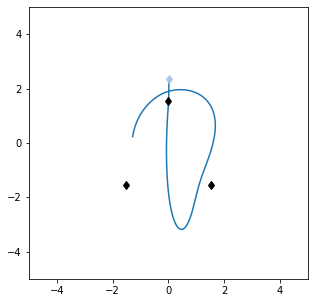

Predictions are [ 0.01930819  0.04000057 -0.09837244]
Charges are [-0.6685254  -0.9815461  -0.96638537]


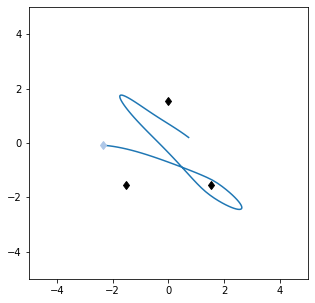

Predictions are [ 0.03997343  0.00422655 -0.07265332]
Charges are [-0.91167294 -0.90831124 -0.75699005]


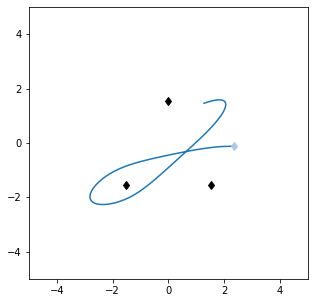

Predictions are [ 0.04502838  0.00718023 -0.06172892]
Charges are [-0.89417391 -0.78428705 -0.82146292]


In [60]:
# lookup_value = np.array([-0.9951, -0.4482, -0.2730])
for i in badpredics:
    plot_sim(simulation_test[i])
    print(f'Predictions are {predictions[i][0].cpu().numpy()}')
    print(f'Charges are {charges_test[i]}')
    

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(list_actual[:10], list_predictions[:10]))
print(mean_squared_error(list_actual, list_predictions))

0.6300668512005358
0.33604904271335995


# Task 3.2

## Data Handling and Preprocessing

We create a `collate_batch` method which produces batches of source and target sentences. This method will be used in the 'DataLoader' which enables us to iterate over the dataset in batches. In each iteration, a batch of input and output simulations would be returned. We pad all the sequences to the length of the longest simulation in the batch then we pack the padded simulation for better performance. 

In [78]:
def collate_batch_32(batch):
    '''
    Args:
        batch: batch sizes list of tuples (features, target)
    
    Returns:
        packed input simulation and corresponding targets
    
    '''
    data = [torch.from_numpy(item[0]).float() for item in batch]
    data_lengths = [d.size(0) for d in data]

    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    # packed_data = pack_padded_sequence(padded_data, data_lengths, batch_first=True, enforce_sorted=False)

    # targets = np.array([item[1] for item in batch],dtype=object)
    targets = [torch.from_numpy(item[1]).float() for item in batch]
    target_lengths = [t.size(0) for t in targets]
    padded_target = pad_sequence(targets, padding_value= 0)
    # packed_target = pack_padded_sequence(padded_target, target_lengths, batch_first=True, enforce_sorted=False)

    return padded_data.to(device), padded_target.to(device) 

    # return packed_data.to(device), packed_target.to(device) 

In [79]:
batch_len = 10
train_loader_32 = DataLoader(tuple(zip(simulation_train_task32, simulation_continued_train[:])), batch_size = batch_len, 
                        collate_fn = collate_batch_32)

### workspace

In [83]:
batch = list(zip(simulation_train_task32[:3],simulation_continued_train[:3]))

data = [torch.from_numpy(item[0]).float() for item in batch]
lengths = [d.size(0) for d in data]

padded_data = pad_sequence(data, batch_first=True, padding_value=0) # pad until batch size is met
packed_data = pack_padded_sequence(padded_data, lengths, batch_first=True, enforce_sorted=False)
targets = np.array([item[1] for item in batch],dtype=object)

## Model Implementation

In the implementation we define three objects: the encoder, the decoder and a full translation model that encapsulates the encoder and decoder.

In [84]:
#todo https://github.com/lkulowski/LSTM_encoder_decoder/blob/master/code/lstm_encoder_decoder.py

class Encoder(nn.Module):
    def __init__(self, inp_size=2, hidden_size=110, n_layers=2, batch_size= batch_len, dropout=0.5):
        super(Encoder, self).__init__()

        self.inp_size = inp_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size

        self.rnn = nn.LSTM(
            input_size = self.inp_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            dropout = dropout,
            batch_first = True
        )

    def forward(self, X):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector 
        
        Input:
        src shape:  [max_seq_len_in_batch, batch_size]

        Output:
        hidden and cell dense vectors (hidden and cell)
        which contains all sentence information, shape [n layers, batch size, hid dim]
        """
        
        ### Your code here ###
        #src = [src len, batch size]

        _, (hidden, cell) = self.rnn(X)
        
        return hidden, cell

In [89]:
class Decoder(nn.Module):
    def __init__(self, input_size =2, hid_dim=110, n_layers=2, dropout=0.5):
        super().__init__()
        
        
        self.input_size = input_size
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        # self.embedding = nn.Embedding(1, emb_dim)
        
        self.rnn = nn.LSTM(input_size, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, input_size)
        
        self.dropout = nn.Dropout(dropout)
    
        
    def forward(self, input, encoder_hidden, encoder_cell):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sentence in
        the target language
        
        Input:
        hidden shape: [n layers, batch size, hid dim]
        cell shape: [n layers, batch size, hid dim]
        input shape: [batch size]  # 1 token for each sentence in the batch
        
        Output:
        prediction shape: [batch size, num_words_target_vocabulary]
        hidden shape: [n layers, batch size, hid dim]
        cell shape: [n layers, batch size, hid dim]
        """
        
       
        lstm_out, (self.hidden, self.cell) = self.rnn(input.unsqueeze(0), (encoder_hidden, encoder_cell))
          
        output = self.fc_out(lstm_out.squeeze(0))  # squeeze our 'sequence length 1' away
        
        return output, self.hidden, self.cell

In [94]:
import torch.optim as optim
import random

class lstm_seq2seq(nn.Module):
    '''Train LSTM encoder-decoder and make predictions '''
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.optimizer = optim.Adam(self.parameters())
        # self.criterion = nn.MSELoss()

    def forward(self, src, trg, teacher_forcing_ration=0.5):
        # calculate number of batch iterations
        trg_len = trg.shape[0]
        outputs = torch.zeros(trg_len, batch_len,2).to(device)

        hidden,cell = self.encoder(src)

        decoder_input = hidden[:,:,-1].T

        for t in range(1, trg_len):

            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio 
            decoder_input = trg[t,:,:] if teacher_force else decoder_output

        return outputs        

In [95]:
def rmse_loss(input, target, ignored_index, reduction='mean'):
    mask = target == ignored_index
    out = (input[~mask]-target[~mask])**2
    if reduction == "mean":
        return torch.sqrt(out.mean())
    elif reduction == "None":
        return out

In [96]:
import random
batch_size = batch_len

encoder = Encoder(n_layers=2).to(device)
decoder = Decoder().to(device)
teacher_forcing_ratio=0.5

# criterion = nn.MSELoss(ignore_index = 0)

for src, trg in train_loader_32:

    trg_len = trg.shape[0]
    outputs = torch.zeros(trg_len, batch_size,2).to(device)

    hidden,cell = encoder(src)  
    decoder_input = hidden[:,:,-1].T
    # print(de_input.T.shape)

    for t in range(1, trg_len):

        decoder_output, hidden, cell = decoder(decoder_input, hidden, cell)
        outputs[t] = decoder_output
        teacher_force = random.random() < teacher_forcing_ratio 
        decoder_input = trg[t,:,:] if teacher_force else decoder_output
        # break

    break



## Model Training

In [97]:
#todo
enc = encoder = Encoder(n_layers=2)
dec = Decoder()

seq2seq = lstm_seq2seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
seq2seq.apply(init_weights)

lstm_seq2seq(
  (encoder): Encoder(
    (rnn): LSTM(2, 110, num_layers=2, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder(
    (rnn): LSTM(2, 110, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=110, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [98]:
from tqdm import tqdm

seq2seq.train()
CLIP =1
clip = CLIP
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0
    for src, trg in tqdm(train_loader_32):
        seq2seq.optimizer.zero_grad()
        output = seq2seq(src, trg)
        loss = rmse_loss(output, trg, ignored_index=0)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), clip)
        seq2seq.optimizer.step()
        epoch_loss += loss.item()
        torch.cuda.empty_cache()
        # break
    print(epoch_loss/len(train_loader_32))
    

100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


1.6760386149088542


100%|██████████| 15/15 [00:01<00:00,  8.26it/s]


1.3485526323318482


100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


1.1211012959480287


100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


1.0049308975537619


100%|██████████| 15/15 [00:01<00:00,  7.53it/s]


0.8300370573997498


100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


0.6945064743359883


100%|██████████| 15/15 [00:01<00:00, 10.69it/s]


0.6585508028666178


100%|██████████| 15/15 [00:01<00:00, 10.65it/s]


0.593600704272588


100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


0.5870915035406749


100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


0.5851845443248749


100%|██████████| 15/15 [00:01<00:00, 10.74it/s]


0.5439537743727366


100%|██████████| 15/15 [00:01<00:00, 10.89it/s]


0.5306487282117208


100%|██████████| 15/15 [00:01<00:00, 10.48it/s]


0.5208226462205251


100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


0.5130146284898122


100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


0.5138933837413788


100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


0.5259486079216004


100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


0.5152008096377055


100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


0.5125312129656474


100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


0.5055969456831614


100%|██████████| 15/15 [00:01<00:00,  8.72it/s]

0.4923553744951884


## Evaluation

In [11]:
#todo